> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [2]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [48]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.constant(0.005, dtype=tf.float32, name="D_a")#tf.Variable([1.0], dtype=tf.float32, 
                                   #name="D_a", 
                                   #constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.constant(0.0, dtype=tf.float32, name="sigma_a")#tf.Variable([0.0], dtype=tf.float32)#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.constant(0.02, dtype=tf.float32, name="rho_s")#tf.Variable([1.00], dtype=tf.float32, 
                                     #name="rho_s",
                                    #constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.25, dtype=tf.float32)#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
        
        #self.loss_params = tf.math.abs(1e-8/(self.D_s + 1e-16), name="D_s_inv") + \
        #                   tf.math.abs(1e-8/(self.sigma_s + 1e-16), name="sigma_s_inv") + \
        #                   tf.math.abs(1e-8/(self.mu_a + 1e-16), name="mu_a_inv") + \
        #                   tf.math.abs(1e-8/(self.rho_a + 1e-16), name="rho_a_inv") + \
        #                   tf.math.abs(1e-8/(self.kappa_a + 1e-16), name="kappa_a_inv")   
        
        #self.loss_no_zero_a = tf.math.abs(1e-1/(tf.reduce_mean(self.a_pred) + 1e-16), name="a_pred_inv")
        #self.loss_no_zero_1 = tf.math.abs(1e-1/(tf.reduce_mean(self.s_pred) + 1e-16), name="s_pred_inv")

        self.loss = self.loss_1 + 100*self.loss_a + 100*self.loss_s #+ \
                     #self.loss_no_zero_a + self.loss_no_zero_1
                    #self.loss_params + self.loss_no_zero_a + self.loss_no_zero_1

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_t_temp = tf.identity(a_t, name="temp_a_t")
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        a_diff_temp = tf.identity(a_xx + a_yy, name="temp_a_diff")
        
        s_t = tf.gradients(s, t, name="s_t")[0]
        s_t_temp = tf.identity(s_t, name="temp_s_t")
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        s_diff_temp = tf.identity(s_xx + s_yy, name="temp_s_diff")
        
        f = a*a*s/(1 + kappa_a*a*a)
        kin_temp = tf.identity(f, name="temp_kin")
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, loss_a, loss_s, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train(self, nIter, early_stop_thresh = None, print_iter = 100): 
        
        

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100): 
        
        

        
        data_n = self.x.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        data = np.concatenate([self.x, self.y, self.t, self.a, self.s], 1)
        indices = np.array(list(range(data_n)))
        
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices)
            total_loss = 0
            total_loss_a = 0
            total_loss_s = 0
            
            for batch in range(batch_steps):
                start = batch*batch_size
                end = (batch+1)*batch_size
                end = end - (end//data_n)*(end%data_n)
                
                batch_indices = indices[start:end]
                
                tf_dict = {self.x_tf: data[batch_indices, 0:1], 
                           self.y_tf: data[batch_indices, 1:2], 
                           self.t_tf: data[batch_indices, 2:3],
                           self.a_tf: data[batch_indices, 3:4], 
                           self.s_tf: data[batch_indices, 4:5]}
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                
                total_loss += loss_value
                total_loss_a += loss_a_value
                total_loss_s += loss_s_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]

                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss.tolist()},\n"                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()

            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]

                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss.tolist()},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break    
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_a, self.D_s,
                                          self.sigma_a, self.sigma_s,
                                          self.rho_a, self.rho_s,
                                          self.mu_a, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [49]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [ ]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
model.train_batch(20000, batch_size=N*T//32, early_stop_thresh=10.0, print_iter=100)

It: 0, loss_a  : 13.21907073, loss_s  : 31688.86602783, loss  : 3235414.0625,
D_a: 0.004999999888241291, D_s: [1.0349104404449463]
sigma_a: 0.0, sigma_s: [0.9680920839309692]
rho_a: [1.009461522102356], rho_s: 0.019999999552965164
mu_a: [0.9832454919815063], kappa_a: [0.9955205917358398], 
Time:5.41

It: 100, loss_a  : 0.26341923, loss_s  : 0.16422692, loss  : 9560.21957397461,
D_a: 0.004999999888241291, D_s: [2.4603874683380127]
sigma_a: 0.0, sigma_s: [0.01506826002150774]
rho_a: [0.5613216161727905], rho_s: 0.019999999552965164
mu_a: [0.4039037525653839], kappa_a: [0.7666855454444885], 
Time:296.27

It: 200, loss_a  : 1.38310294, loss_s  : 0.47893708, loss  : 8536.942398071289,
D_a: 0.004999999888241291, D_s: [2.4475486278533936]
sigma_a: 0.0, sigma_s: [0.01300891675055027]
rho_a: [0.5174010396003723], rho_s: 0.019999999552965164
mu_a: [0.3506692945957184], kappa_a: [0.8617448210716248], 
Time:305.85

It: 300, loss_a  : 1.36081869, loss_s  : 0.55153899, loss  : 3061.917022705078,
D_a

In [16]:
model.train_batch(20000, batch_size=N*T//32, early_stop_thresh=5.0, print_iter=100)

It: 0, loss_a  : 0.04272943, loss_s  : 0.00386940, loss  : 12.840289980173111,
D_a: 0.004999999888241291, D_s: [0.003045462304726243]
sigma_a: 0.0, sigma_s: [0.0016872603446245193]
rho_a: [0.0008151670335792005], rho_s: 0.019999999552965164
mu_a: [9.99999993922529e-09], kappa_a: [12.413474082946777], 
Time:2.40

It: 100, loss_a  : 0.04331659, loss_s  : 0.00278668, loss  : 15.826503366231918,
D_a: 0.004999999888241291, D_s: [0.002404947765171528]
sigma_a: 0.0, sigma_s: [0.0015048814238980412]
rho_a: [0.0014963665744289756], rho_s: 0.019999999552965164
mu_a: [9.99999993922529e-09], kappa_a: [14.630610466003418], 
Time:237.03

It: 200, loss_a  : 0.04382710, loss_s  : 0.00194188, loss  : 7.571397230029106,
D_a: 0.004999999888241291, D_s: [0.0014623120659962296]
sigma_a: 0.0, sigma_s: [0.001249524299055338]
rho_a: [0.0018928819335997105], rho_s: 0.019999999552965164
mu_a: [9.99999993922529e-09], kappa_a: [16.812091827392578], 
Time:237.21

It: 300, loss_a  : 0.04423625, loss_s  : 0.00148414

In [ ]:
model.minimise(max_iter=100)  

# Estimated parameters

In [17]:

def print_vals(name, value, actual):
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/actual:0.8f}")
    
print(f"D_a: {model.sess.run(model.D_a):0.8f}, actual: 0.005, "
      f"difference: {np.abs(0.005-model.sess.run(model.D_a)):0.8f}, relative: %{100*np.abs(0.005-model.sess.run(model.D_a))/0.005:0.8f}")
print("---------------")
print_vals("D_s", model.sess.run(model.D_s)[0], 0.2)
print_vals("sigma_s", model.sess.run(model.sigma_s)[0], 0.02)
print_vals("rho_a", model.sess.run(model.rho_a)[0], 0.01)
print_vals("mu_a", model.sess.run(model.mu_a)[0], 0.01)
print_vals("kappa_a", model.sess.run(model.kappa_a)[0], 0.01)

D_a: 0.00500000, actual: 0.005, difference: 0.00000000, relative: %0.00000224
---------------
D_s: 0.00061816, actual: 0.200, difference: 0.19938184, relative: %99.69092073
sigma_s: 0.00086267, actual: 0.020, difference: 0.01913733, relative: %95.68665575
rho_a: 0.00137036, actual: 0.010, difference: 0.00862964, relative: %86.29636597
mu_a: 0.00000001, actual: 0.010, difference: 0.00999999, relative: %99.99990000
kappa_a: 24.27730179, actual: 0.010, difference: 24.26730179, relative: %242673.01788330


In [32]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [33]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00140679
Loss_s : 0.00002506
Loss   : 0.13586994


In [34]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

0.0852724278624469
0.03627897217908803


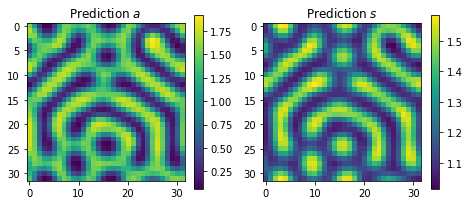

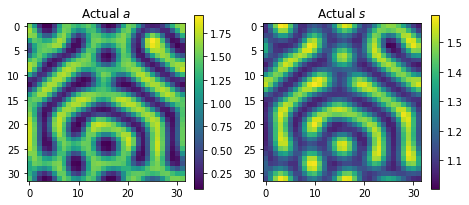

In [35]:
_ = plt.figure(figsize=(12,8))

plt.subplot(131)
plt.title(r"Prediction $a$")
plt.imshow(a_2)
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Prediction $s$")
plt.imshow(s_2)
plt.colorbar(shrink=.4)
plt.show()
_ = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title(r"Actual $a$")
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Actual $s$")
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.show()

In [36]:
graph = tf.get_default_graph()
tmp = graph.get_tensor_by_name("temp_a_t:0")
a_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_t:0")
s_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_a_diff:0")
a_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_diff:0")
s_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_kin:0")
kin = model.sess.run(tmp, tf_dict)

D_a = 0.005000, rho_a = 0.001370, mu_a = 0.000000010, sigma_a = 0.000000000, kappa_a = 24.2773


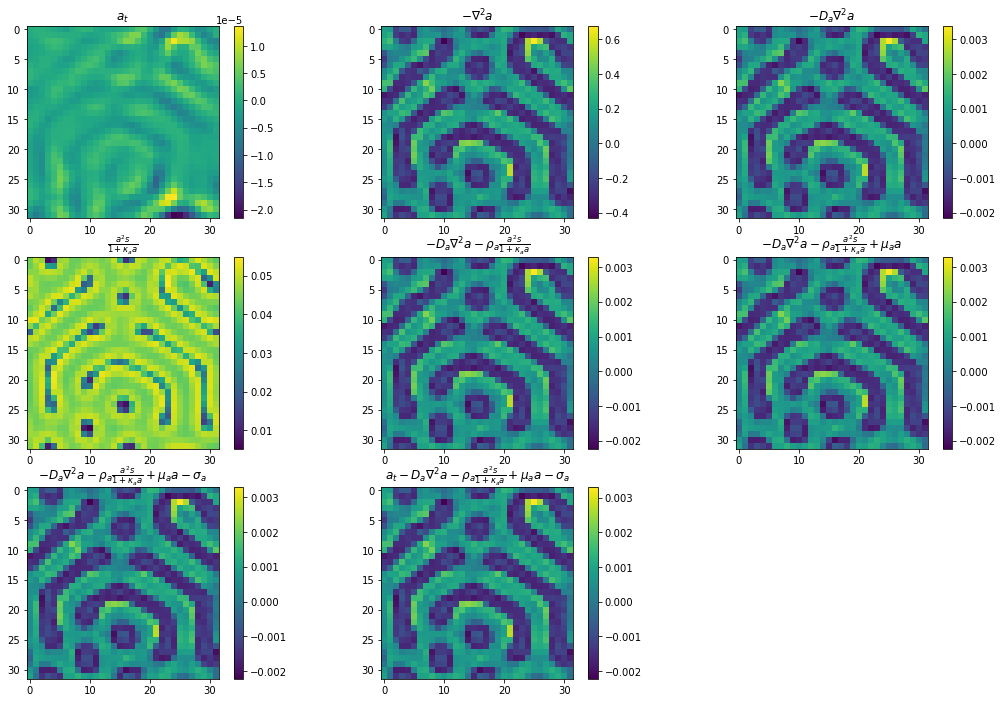

In [45]:
D_a = model.sess.run(model.D_a, tf_dict)
rho_a = model.sess.run(model.rho_a, tf_dict)
mu_a = model.sess.run(model.mu_a, tf_dict)
sigma_a = model.sess.run(model.sigma_a, tf_dict)
kappa_a = model.sess.run(model.kappa_a, tf_dict)[0]
print(f"D_a = {D_a:.6f}, rho_a = {rho_a[0]:.6f}, mu_a = {mu_a[0]:.9f}, sigma_a = {sigma_a:.9f}, kappa_a = {kappa_a:.4f}")

# a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$a_t$")
plt.imshow(a_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 a$")
plt.imshow((-a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_a \nabla^2 a$")
plt.imshow((-D_a*a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$ \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_a*a_diff-rho_a*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 8)
plt.title(r"$a_t-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((a_t-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()


D_s = 0.000618, rho_s = 0.020000, sigma_s = 0.000863, kappa_a = 24.2773


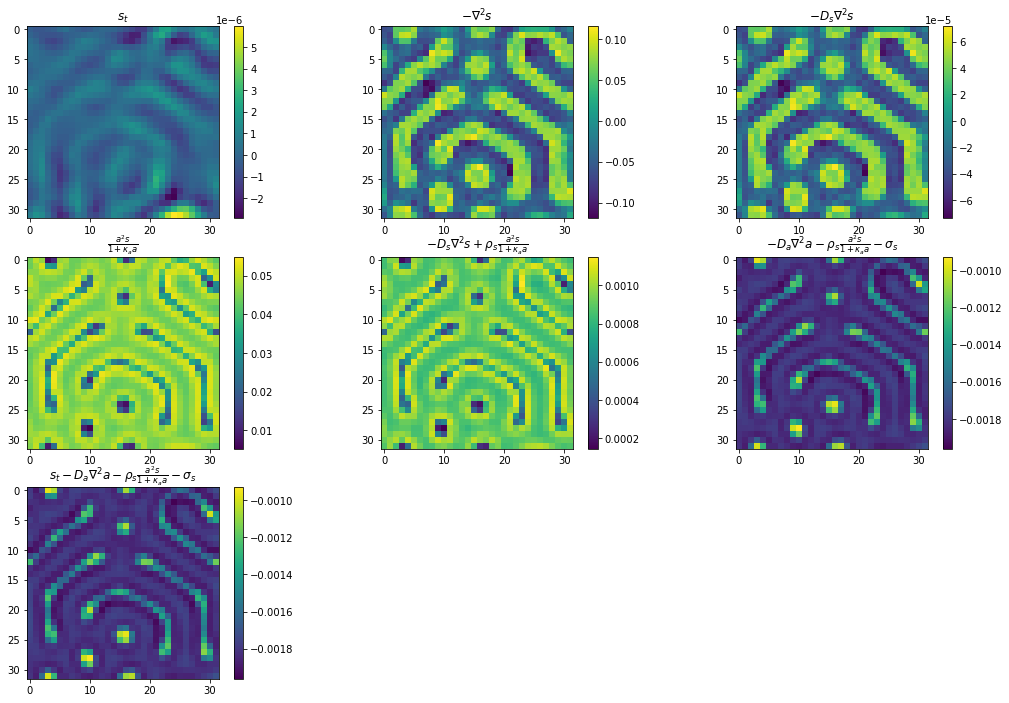

In [47]:
D_s = model.sess.run(model.D_s, tf_dict)
rho_s = model.sess.run(model.rho_s, tf_dict)
sigma_s = model.sess.run(model.sigma_s, tf_dict)
print(f"D_s = {D_s[0]:.6f}, rho_s = {rho_s:.6f}, sigma_s = {sigma_s[0]:.6f}, kappa_a = {kappa_a:.4f}")

# s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$s_t$")
plt.imshow(s_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 s$")
plt.imshow((-s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_s \nabla^2 s$")
plt.imshow((-D_s*s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$\frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_s \nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_s*s_diff+rho_s*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_a \nabla^2 a - \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((-D_s*s_diff-rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$s_t-D_a \nabla^2 a - \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((s_t-D_s*s_diff-rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()